In [ ]:
%pip install gymnasium
%pip install stable_baselines3
%pip install stable_baselines


In [ ]:
%pip install keras
%pip install optuna


In [ ]:
%pip install --upgrade pip

In [1]:
import gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
from gym_anytrading.envs import StocksEnv
import gym_anytrading
import quantstats as qs
import pandas as pd
import matplotlib.pyplot as plt
import logging
import optuna



In [2]:
logger = logging.getLogger('training')
logger.setLevel(logging.INFO)

file_handler = logging.FileHandler('training.log')
formatter = logging.Formatter('%(asctime)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [3]:
import yfinance as yf
vgt_data = yf.download("VGT", period = '5y')
schd_data = yf.download("SCHD", period = '5y')
voo_data = yf.download('VOO', period = '5y')
data = pd.concat([vgt_data, schd_data, voo_data]) 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
#Rolling window split. Two year training data

train_df = data[:2*365]
val_df_1 = data[2*365:3*365]
val_df_2 = data[3*365:4*365]
val_df_3 = data[4*365:5*365]

In [7]:
def ModelCreation():

    #Creating Logging env
    logger = logging.getLogger('training')
    logger.setLevel(logging.INFO)

    file_handler = logging.FileHandler('training.log')
    formatter = logging.Formatter('%(asctime)s - %(message)s')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    #Creating training env

    window_size = 10
    start_index = window_size
    end_index = len(data)

    train_env = gym.make(
            'stocks-v0',
            df = train_df,
            window_size = window_size,
            frame_bound = (start_index, end_index)
        )

    val_env1 = gym.make(
        'stocks-v0',
        df = val_df_1,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )




    val_env2 = gym.make(
        'stocks-v0',
        df = val_df_2,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )



    val_env3 = gym.make(
        'stocks-v0',
        df = val_df_3,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )

    env1 = DummyVecEnv([lambda : train_env, lambda : val_env1, lambda : val_env2, lambda : val_env3])

    #Setting up hyperparameter tuners

    def optimizePPO(trial):
        return {
            'n_steps' : int(trial.suggest_loguniform('n_steps', 16, 2048)),
            'gamma' : trial.suggest_loguniform('gamma', 0.9, 0.9999),
            'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-5, 1.),
            'ent_coef' : trial.suggest_loguniform('ent_coef', 1e-8, 1e-1),
            'clip_range': trial.suggest_uniform('clip_range', 0.1, 0.4),
            'n_epochs' : int(trial.suggest_loguniform('n_epochs', 1, 48)),
            'gae_lambda': trial.suggest_uniform('gae_lambda', 0.8, 1.)
        }

    def OptimizeA2C(trial):

        return {
            'n_steps': trial.suggest_int('n_steps', 16, 2048),
            'gamma': trial.suggest_uniform('gamma', 0.9, 0.9999),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1.),
            'ent_coef': trial.suggest_loguniform('ent_coef', 1e-8, 1e-1),
            'vf_coef': trial.suggest_loguniform('vf_coef', 0.5, 1.) 
        }

    file_handler.close()
    logger.removeHandler(file_handler)

    file_handler = logging.FileHandler('training.log')
    logger.addHandler(file_handler)


    logger.info('Starting Hyperparameter Tuning...')

    
    def Optimize_PPO_agent(trial):
        model_params = optimizePPO(trial)
        env = env1
        model = PPO('MlpPolicy', train_env, verbose=1, **model_params)
        model.learn(10000)

        rewards = []
        global n_steps
        n_steps = 0

        n_episodes, reward_sum = 0, 0.0

        obs = env.reset()
        while n_episodes < 4:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            reward_sum += reward

            if done.all():
                rewards.append(reward_sum)
                reward_sum = 0.0
                n_episodes += 1
                obs = env.reset()

        last_reward = np.mean(rewards)
        trial.report(-1 * last_reward, step = n_steps)

        return -1 * last_reward

    def Optimize_A2C_agent(trial):
        model_params = OptimizeA2C(trial)
        env = env1
        model = A2C('MlpPolicy', train_env, verbose=1, **model_params)
        model.learn(10000)

        rewards = []
        global n_steps
        n_steps = 0

        n_episodes, reward_sum = 0, 0.0

        obs = env.reset()
        while n_episodes < 4:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            reward_sum += reward

            if done.all():
                rewards.append(reward_sum)
                reward_sum = 0.0
                n_episodes += 1
                obs = env.reset()

        last_reward = np.mean(rewards)
        trial.report(-1 * last_reward, step = n_steps)

        return -1 * last_reward


    ppo_study = optuna.create_study()
    ppo_study.optimize(Optimize_PPO_agent, n_trials = 1)

    a2c_study = optuna.create_study()
    a2c_study.optimize(Optimize_A2C_agent, n_trials = 1)

    ppo_best_params = ppo_study.best_params
    ppo_best_params['clip_range'] = float(ppo_best_params['clip_range'])
    ppo_best_params['n_steps'] = int(ppo_best_params['n_steps'])
    ppo_best_params['n_epochs'] = int(ppo_best_params['n_epochs'])
    
    a2c_best_params = a2c_study.best_params

    logger.info(f'Hyperparameter tuning is complete. The A2C best parameters are: {a2c_best_params} and the best PPO parameters are: {ppo_best_params}')

    logger.info('Initializing the PPO and A2C models...')
    ppo_agent = PPO('MlpPolicy', train_env, verbose=1, **ppo_best_params)
    a2c_agent = A2C('MlpPolicy', train_env, verbose=1, **a2c_best_params)

    logger.info('Training the PPO Agent...')
    ppo_agent.learn(total_timesteps=10000)

    logger.info('Training the A2C Agent...')
    a2c_agent.learn(total_timesteps=10000)

    logger.info('Training is complete')


    envs = [val_env1, val_env2, val_env3]

    def evalModel():

        num_years = 3
        counter = 3

        while counter <= num_years:

            for i in envs:
                ppo_rewards = []
                obs1 = i.reset()

                while True:
                    action, _ = ppo_agent.predict(obs1)
                    logger.info(f'PPO Took action {action} in state {obs1}')
                    obs, reward, done, info = i.step(action)
                    ppo_rewards.append(reward)

                    if done:
                        break

                print(f'PPO average validation for year {counter} reward: ', np.mean(ppo_rewards))


                a2c_rewards = []
                obs2 = val_env1.reset()

                while True:
                    action, _ = a2c_agent.predict(obs2)
                    obs, reward, done, info = val_env1.step(action)
                    a2c_rewards.append(reward)

                    if done:
                        break

                print(f'A2C average validation for year {counter} reward: ', np.mean(a2c_rewards))

                if np.mean(ppo_rewards) > np.mean(a2c_rewards):
                    agent = ppo_agent
                    action, _ = agent.predict(obs1)
                    print(f'Agent chosen for year {counter} is PPO')
                else:
                    agent = a2c_agent
                    action, _ = agent.predict(obs2)
                    print(f'Agent chosen for year {counter} is A2C')

                counter += 1

                plt.figure(figsize = (16,6))
                i.render_all()
                plt.show()

                #.bar(np.arange(len(ppo_val)), ppo_val, label = 'PPO')
                #.bar(np.arange(len(a2c_val)), a2c_val, label = 'A2C')
                #.xlabel(f'Validation Performance for year {counter}')
                #.ylabel('Average Reward')
                #.legend()
                #.show()

        



        print("info:", info)
        plt.plot(ppo_rewards, label = 'PPO')
        plt.plot(a2c_rewards, label = 'A2C')

        plt.legend()
        plt.title('Agent Rewards')
        plt.show()



    evalModel()


    




C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 2)
  logger.warn(
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
[I 2023-08-04 09:09:52,512] A new study created in memory with name: no-name-a613dc51-9da7-4da2-9149-

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1889 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 49   |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1211         |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 98           |
| train/                  |              |
|    approx_kl            | 0.0077747814 |
|    clip_fraction        | 0.441        |
|    clip_range           | 0.22         |
|    entropy_loss         | -0.667       |
|    explained_variance   | -0.00128     |
|    learning_rate        | 0.00273      |
|    loss                 | 2.96         |
|    n_updates            | 8            |
|    policy_gradient_loss | -0.00286     |
|    val

C:\Users\12016\AppData\Local\Temp\ipykernel_2108\1785270477.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'n_steps' : int(trial.suggest_loguniform('n_steps', 16, 2048)),
C:\Users\12016\AppData\Local\Temp\ipykernel_2108\1785270477.py:58: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 0.9, 0.9999),
C:\Users\12016\AppData\Local\Temp\ipykernel_2108\1785270477.py:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_rat

-----------------------------------------
| time/                   |             |
|    fps                  | 1018        |
|    iterations           | 4           |
|    time_elapsed         | 0           |
|    total_timesteps      | 196         |
| train/                  |             |
|    approx_kl            | 0.009198185 |
|    clip_fraction        | 0           |
|    clip_range           | 0.22        |
|    entropy_loss         | -0.691      |
|    explained_variance   | 0           |
|    learning_rate        | 0.00273     |
|    loss                 | 4.17        |
|    n_updates            | 24          |
|    policy_gradient_loss | 0.0107      |
|    value_loss           | 15.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1002        |
|    iterations           | 5           |
|    time_elapsed         | 0           |
|    total_timesteps      | 245   

[I 2023-08-04 09:17:12,551] Trial 0 finished with value: 12963.7734375 and parameters: {'n_steps': 49.89667960695007, 'gamma': 0.9521912491043131, 'learning_rate': 0.00272938575477199, 'ent_coef': 0.0001987827709954284, 'clip_range': 0.21978188401560694, 'n_epochs': 8.849657869793868, 'gae_lambda': 0.9890149120820826}. Best is trial 0 with value: 12963.7734375.
[I 2023-08-04 09:17:12,552] A new study created in memory with name: no-name-0bb77654-601f-44a2-8427-d35a2531c3b9
C:\Users\12016\AppData\Local\Temp\ipykernel_2108\1785270477.py:70: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'gamma': trial.suggest_uniform('gamma', 0.9, 0.9999),
C:\Users\12016\AppData\Local\Temp\ipykernel_2108\1785270477.py:71: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rel

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 719      |
|    ep_rew_mean        | 146      |
| time/                 |          |
|    fps                | 1748     |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 5000     |
| train/                |          |
|    entropy_loss       | -0.501   |
|    explained_variance | 0        |
|    learning_rate      | 0.00178  |
|    n_updates          | 99       |
|    policy_loss        | -0.186   |
|    value_loss         | 24.4     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 719      |
|    ep_rew_mean        | 152      |
| time/                 |          |
|    fps                | 1752     |
|    iterations         | 200      |
|    time_elapsed 

[I 2023-08-04 09:24:33,180] Trial 0 finished with value: 23298.294921875 and parameters: {'n_steps': 50, 'gamma': 0.9537137805911933, 'learning_rate': 0.001781968813071997, 'ent_coef': 1.8855127326272192e-07, 'vf_coef': 0.6654015535674686}. Best is trial 0 with value: 23298.294921875.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1819 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 49   |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1235        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 98          |
| train/                  |             |
|    approx_kl            | 0.015085151 |
|    clip_fraction        | 0.311       |
|    clip_range           | 0.22        |
|    entropy_loss         | -0.676      |
|    explained_variance   | -0.00677    |
|    learning_rate        | 0.00273     |
|    loss                 | 14.8        |
|    n_updates

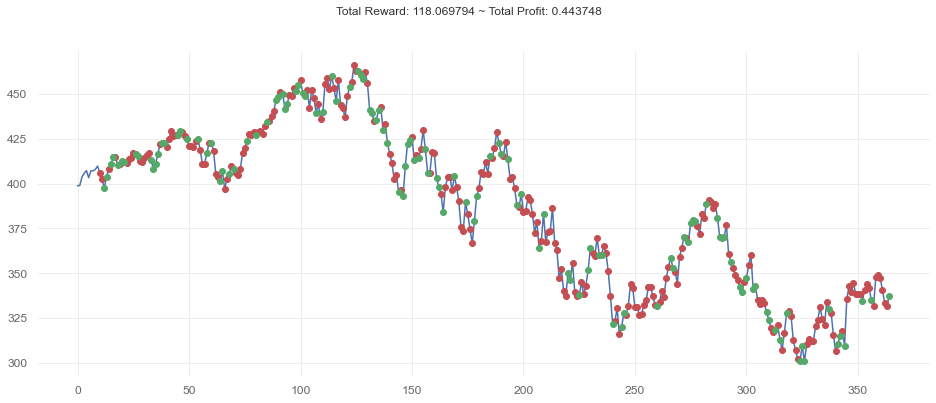

PPO average validation for year 4 reward:  -0.8015256116619218
A2C average validation for year 4 reward:  -0.079095183119262
Agent chosen for year 4 is A2C


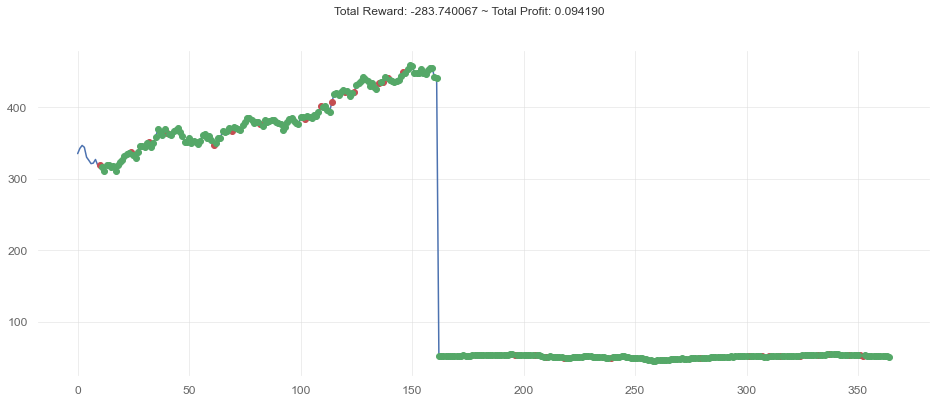

PPO average validation for year 5 reward:  0.0017231440140029132
A2C average validation for year 5 reward:  -0.09113005729718397
Agent chosen for year 5 is PPO


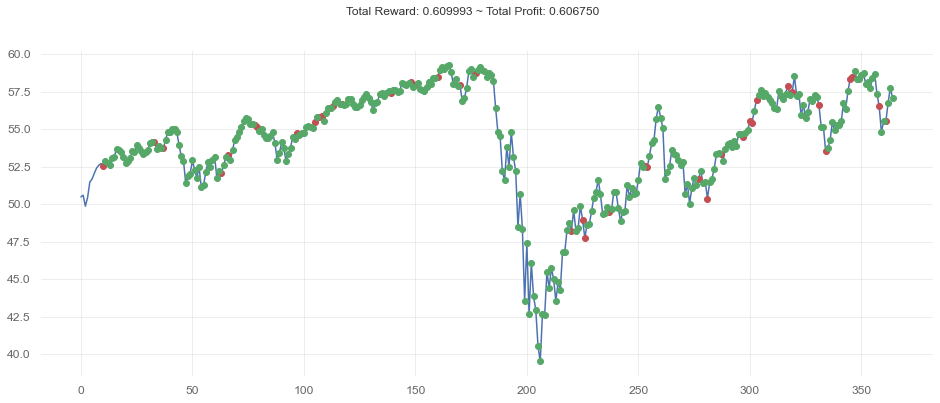

info: {'total_reward': -32.260040283203125, 'total_profit': 0.302869769822465, 'position': 0}


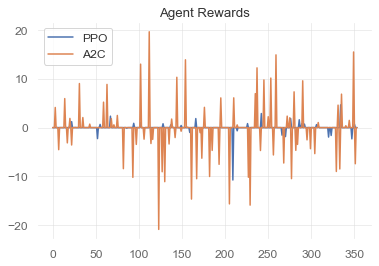

In [8]:
ModelCreation()

In [ ]:
qs.extend_pandas()
for i in envs:
    net_worth = pd.Series(env.history['total_profit'], index=data.index[start_index+1:end_index])
    returns = net_worth.pct_change().iloc[1:]

    qs.reports.full(returns)